In [1]:
#!/usr/bin/env python3
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from model import *
from visual_functions import *
from sweep_configs import *
from wandb.keras import WandbCallback
from create_data import *
from train import *
%matplotlib inline

## ---------------------- load data ----------------------------------------
ins, os, hpr, rn = (72,32,1), 15, (10, 20), 0.05
gen = SynthGen(ins, os, hpr, rn)
X, y = gen.create_dataset(100)

Welcome to JupyROOT 6.26/02


## Toymodel with new dimensions (72x32)

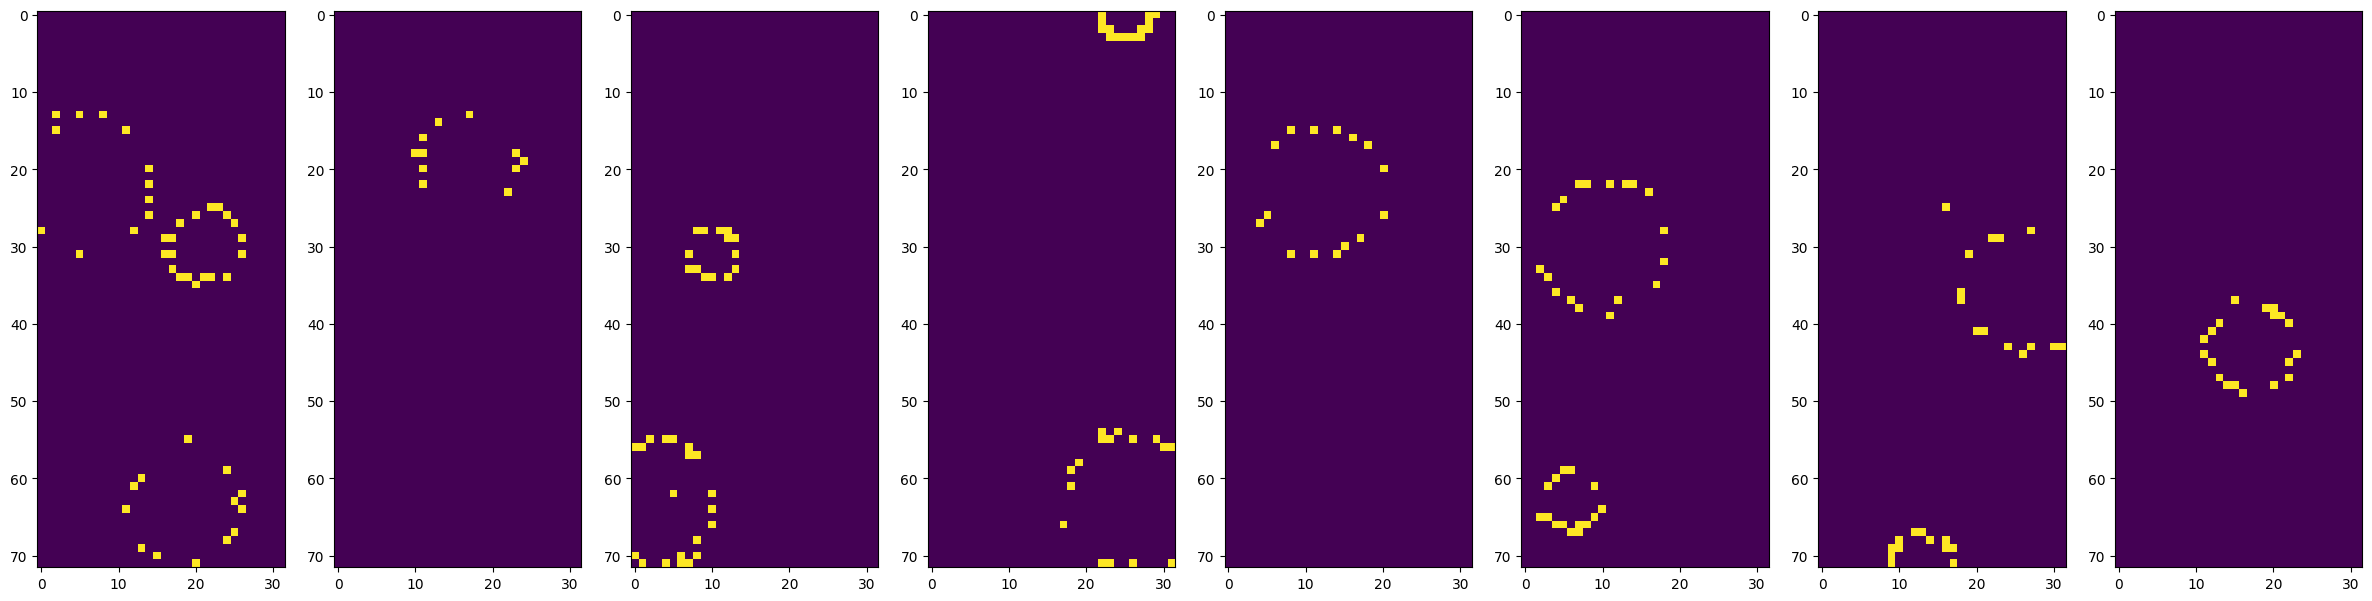

In [2]:
for i in range(1):
    display_data(X, i)
#    plt.imshow(plot_single_event(displays[i], params[i]))
#    plt.show()

## Real/Sim data (mcbm)

load data from  ../data/hits_true.txt  -> 20000  events loaded
(20000, 72, 32, 1)


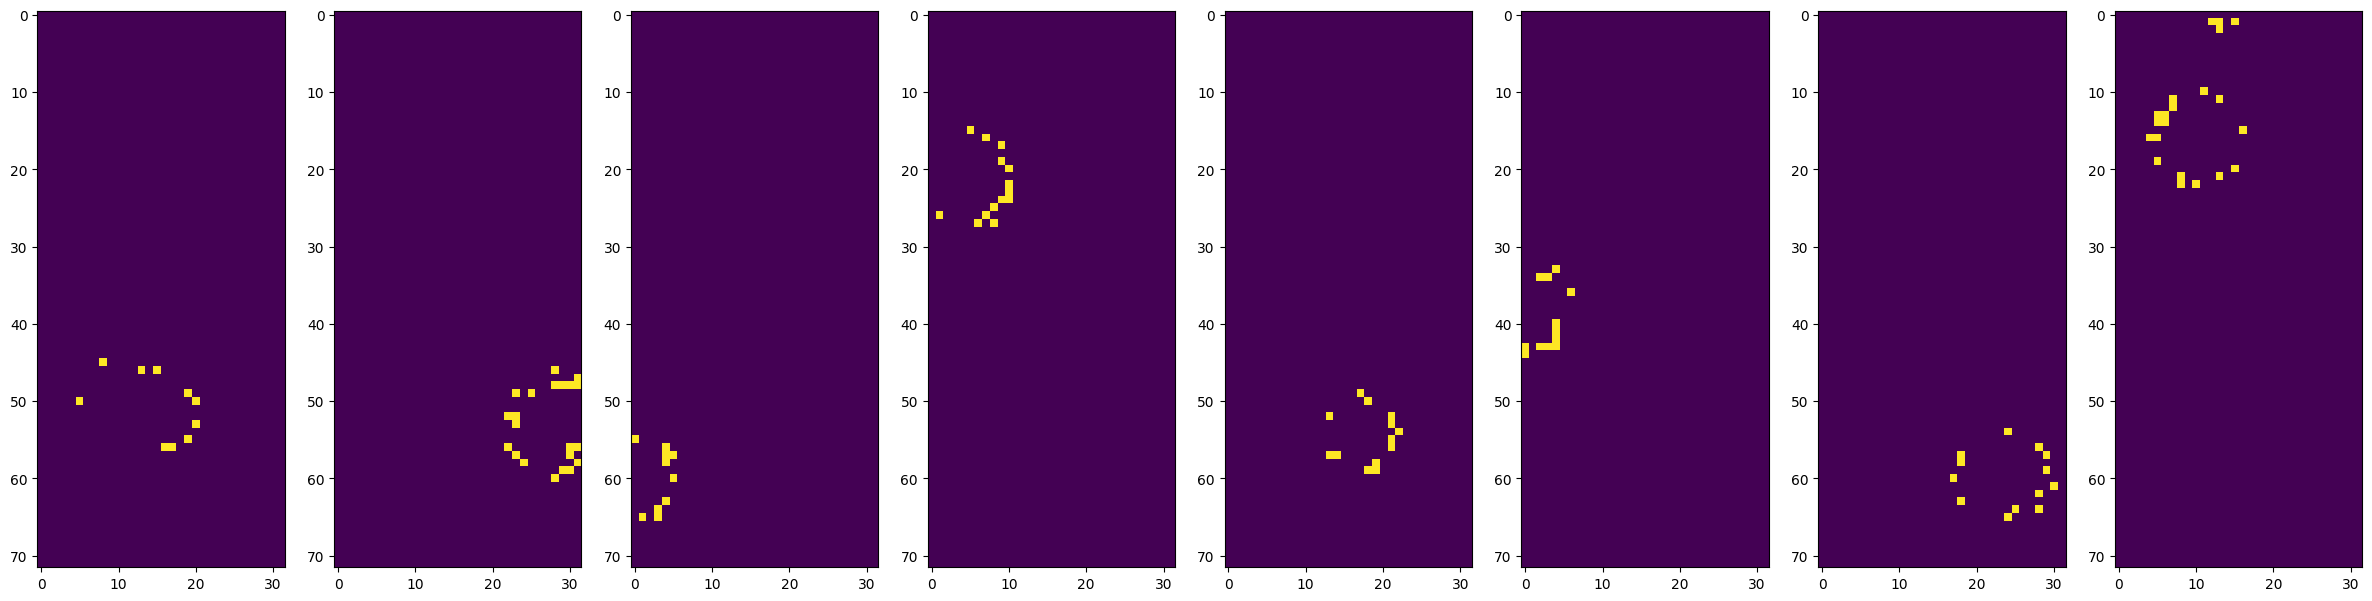

2022-06-01 13:41:20.371659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 13:41:20.395382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 13:41:20.395633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 13:41:20.396260: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# load data file and some preprocessing
def loadDataFile(datafile, pixel_x = 32, pixel_y = 72):
    with open(datafile, 'r') as temp_f:
        col_count = [ len(l.split(",")) for l in temp_f.readlines() ]
    column_names = [i for i in range(0, max(col_count))]
    hits = pd.read_csv(datafile,header=None ,index_col=0,comment='#',
                       delimiter=",", nrows=
                       20000,names=column_names).values.astype('int32')
    hits[hits < 0] = 0
    hits_temp = np.zeros([len(hits[:,0]), pixel_x*pixel_y])
    for i in range(len(hits[:,0])):
        for j in range(len(hits[0,:])):
            if hits[i,j]==0:
                break
            hits_temp[i,hits[i,j]-1]+=1
    hits_temp = tf.reshape(hits_temp, [len(hits[:,0]), pixel_y, pixel_x])
    hits_temp = tf.clip_by_value(hits_temp, clip_value_min=0., clip_value_max=1.)
    hits = tf.cast(hits_temp[..., tf.newaxis],dtype=tf.float32)
    print('load data from  ' + datafile + '  -> ' + str(len(hits[:])) + '  events loaded' )
    return hits

hits_true = loadDataFile("../data/hits_true.txt")
print(hits_true.shape)
for i in range(1):
    display_data(hits_true, i)

## Best model so far

4/4 [==============================] - 1s 85ms/step - loss: 0.2326 - acc: 0.9800


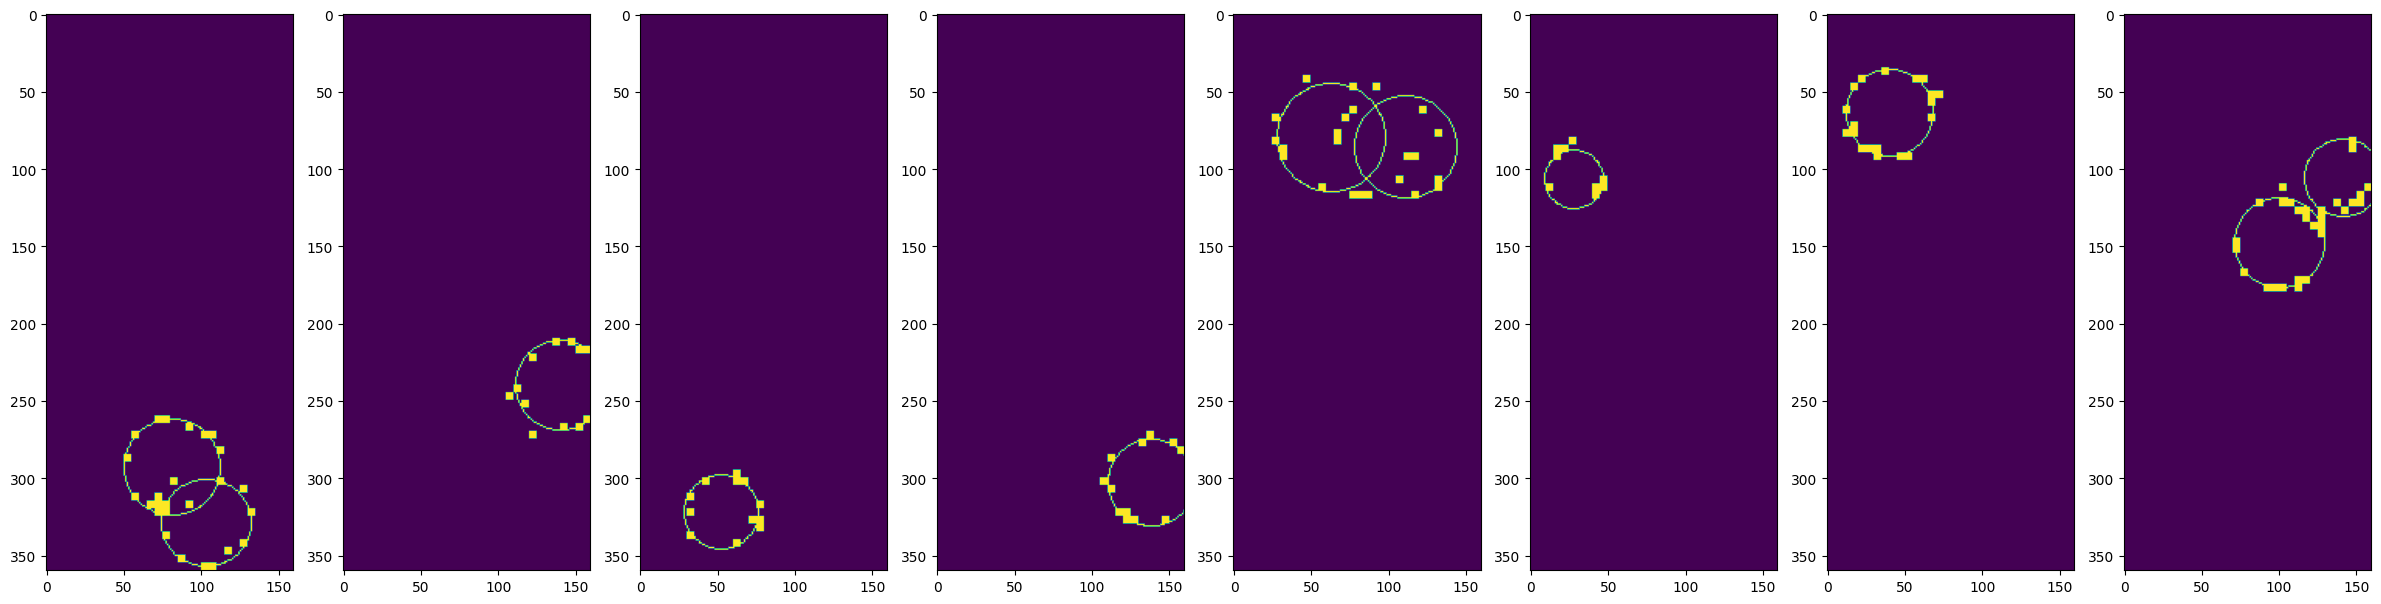

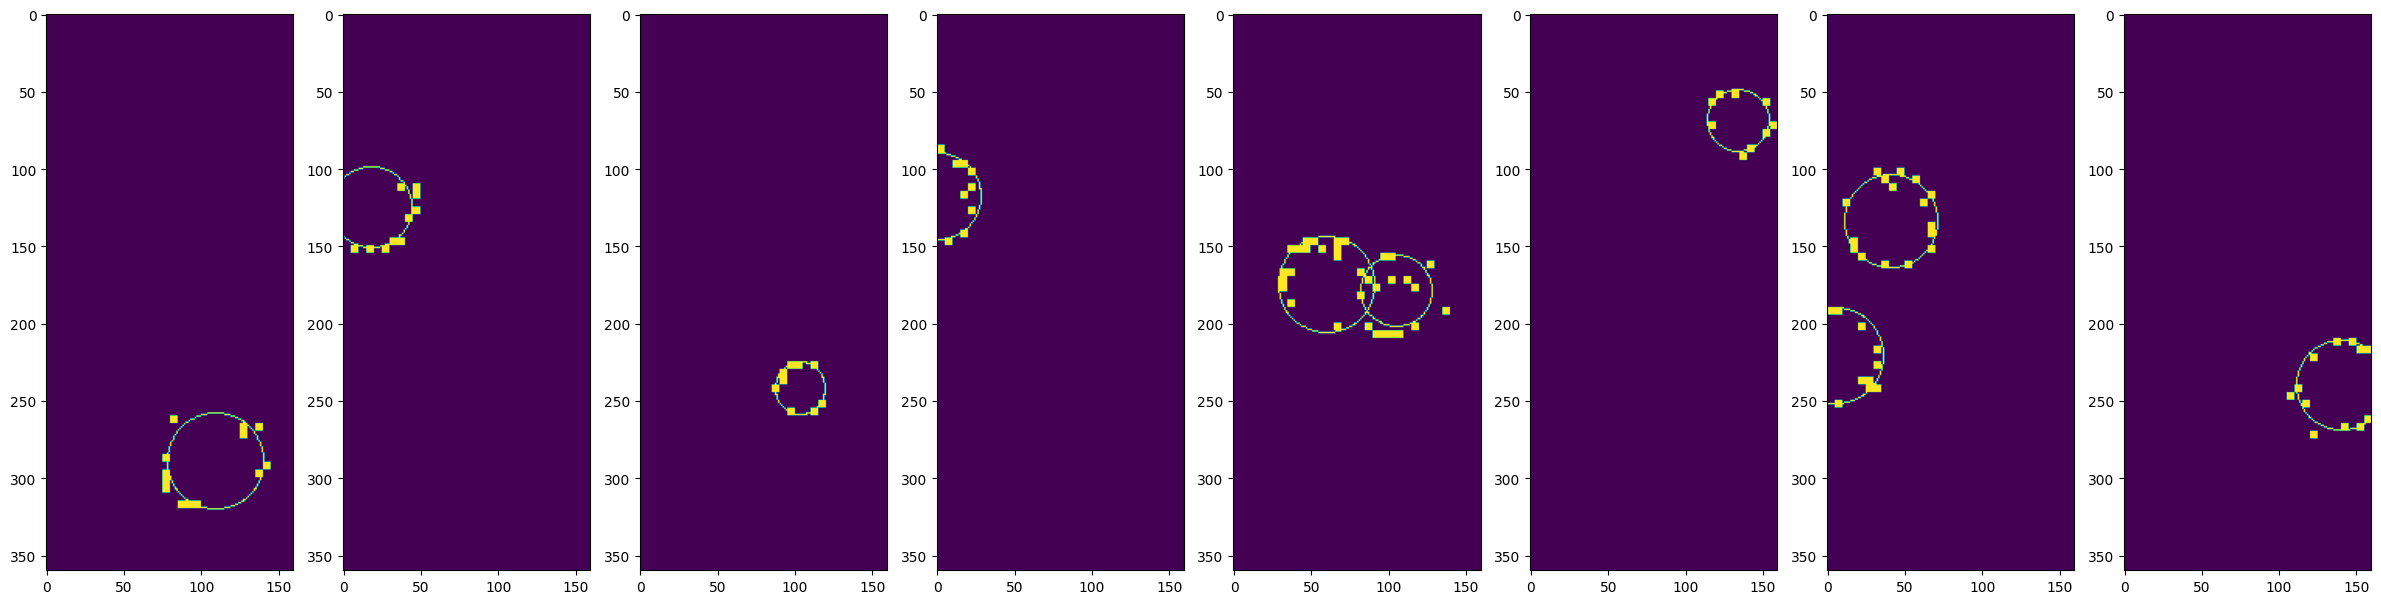

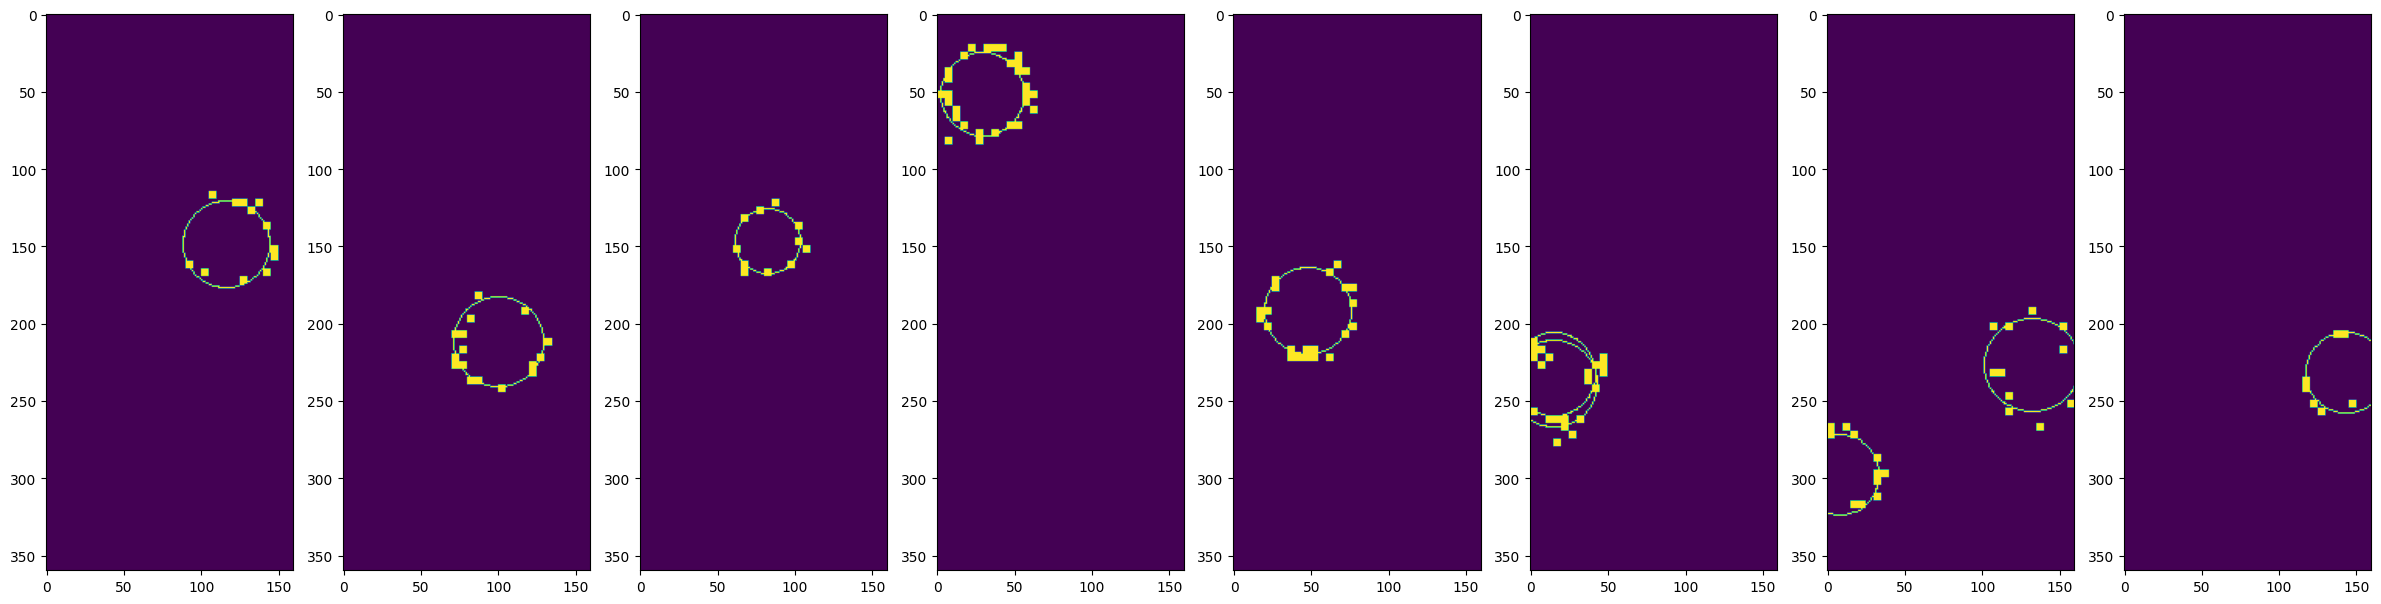

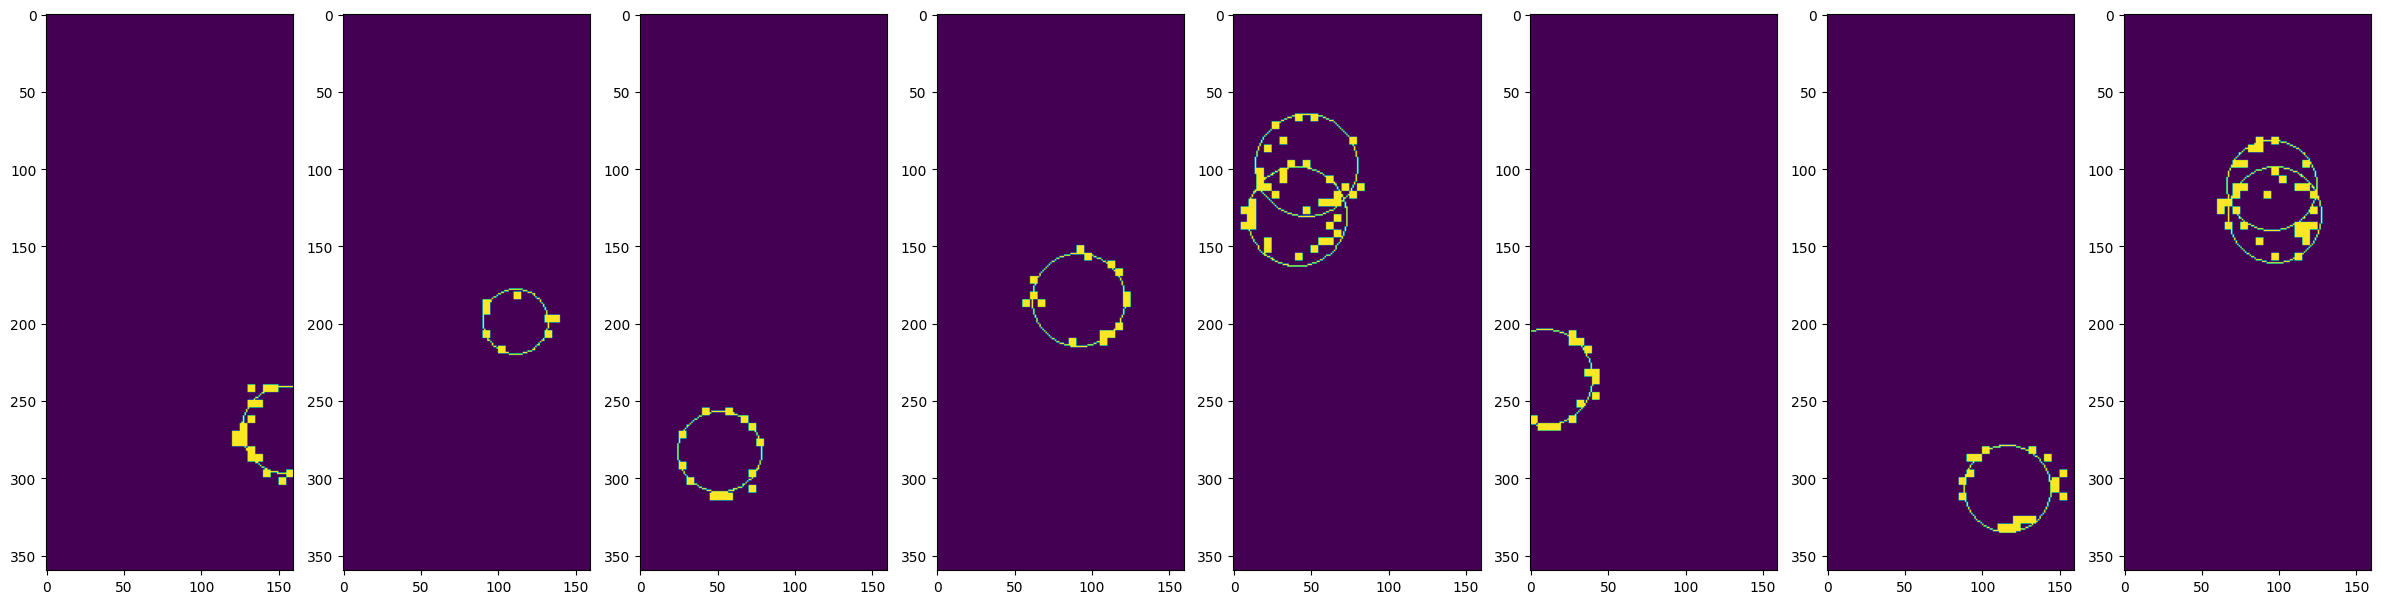

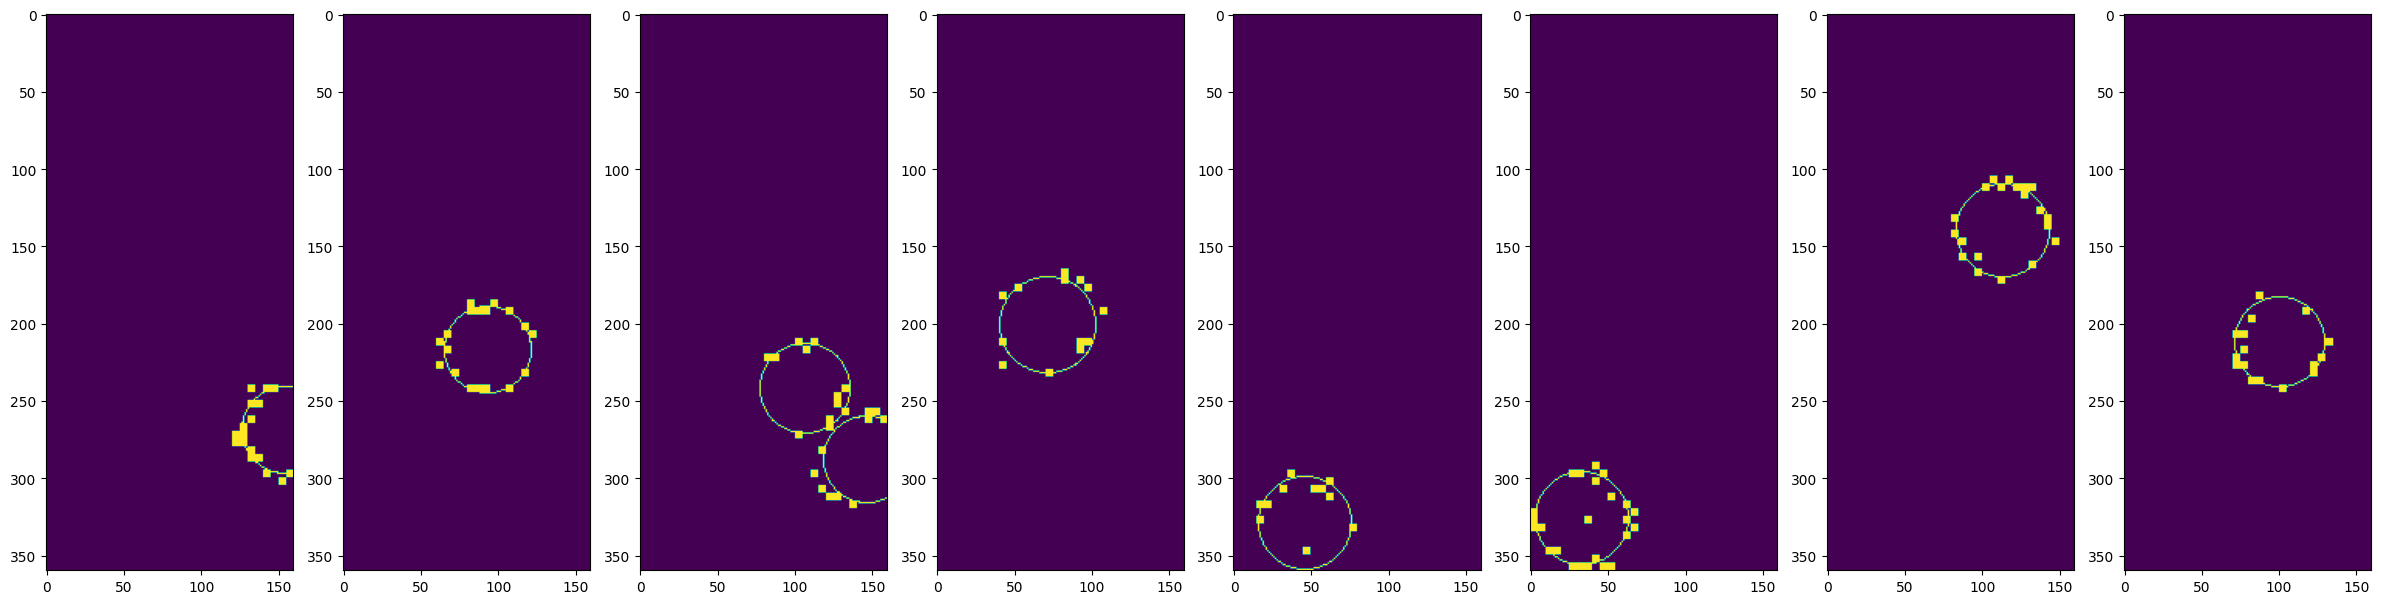

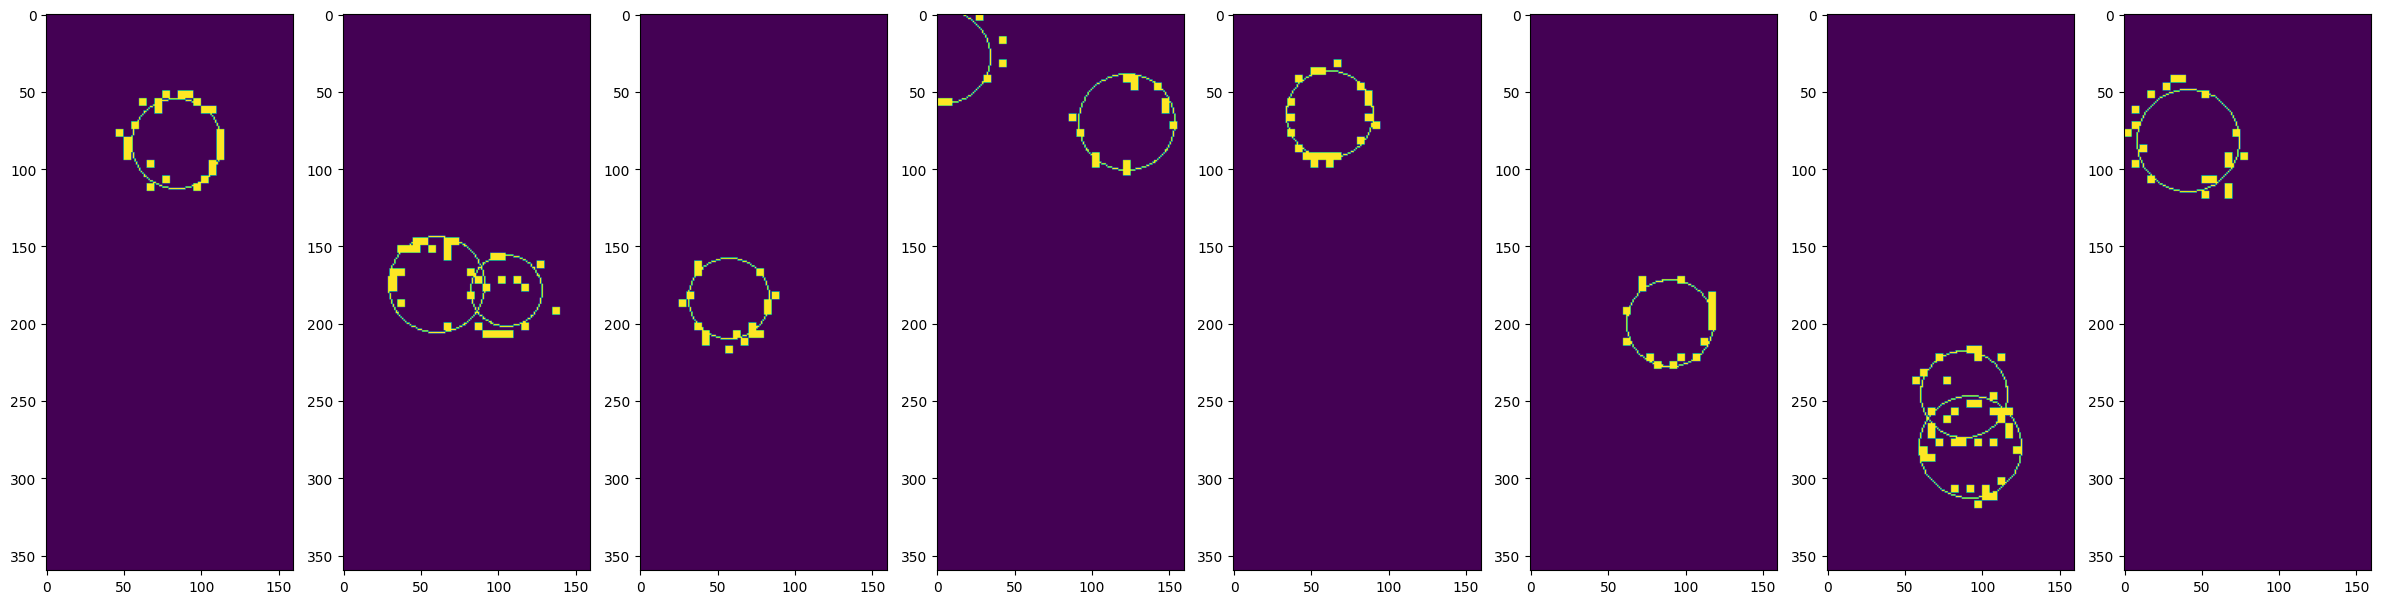

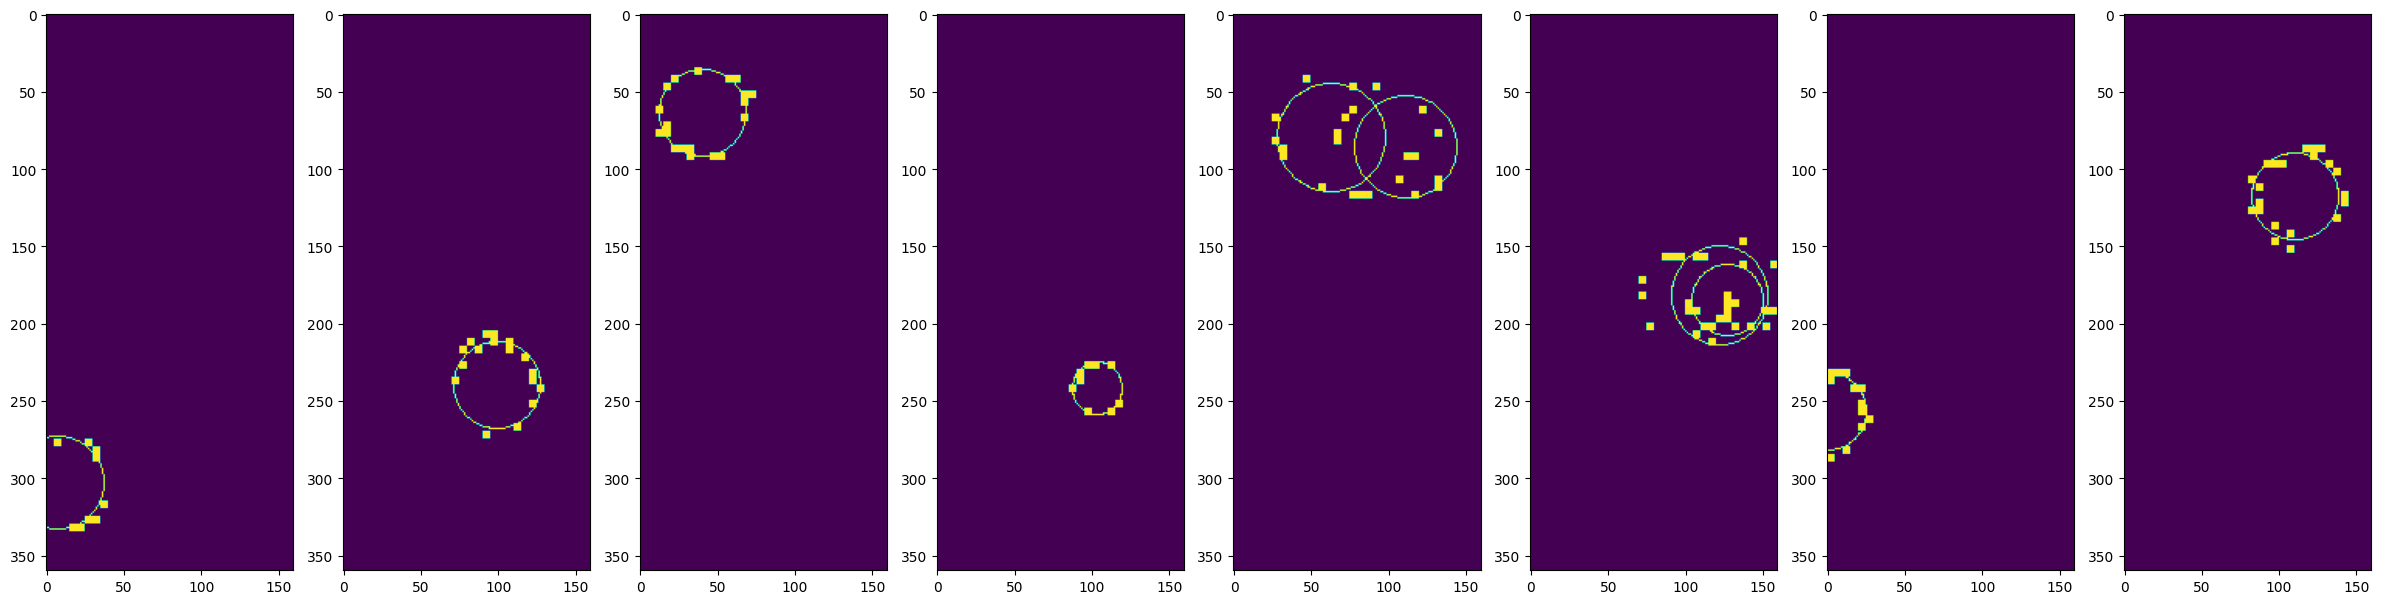

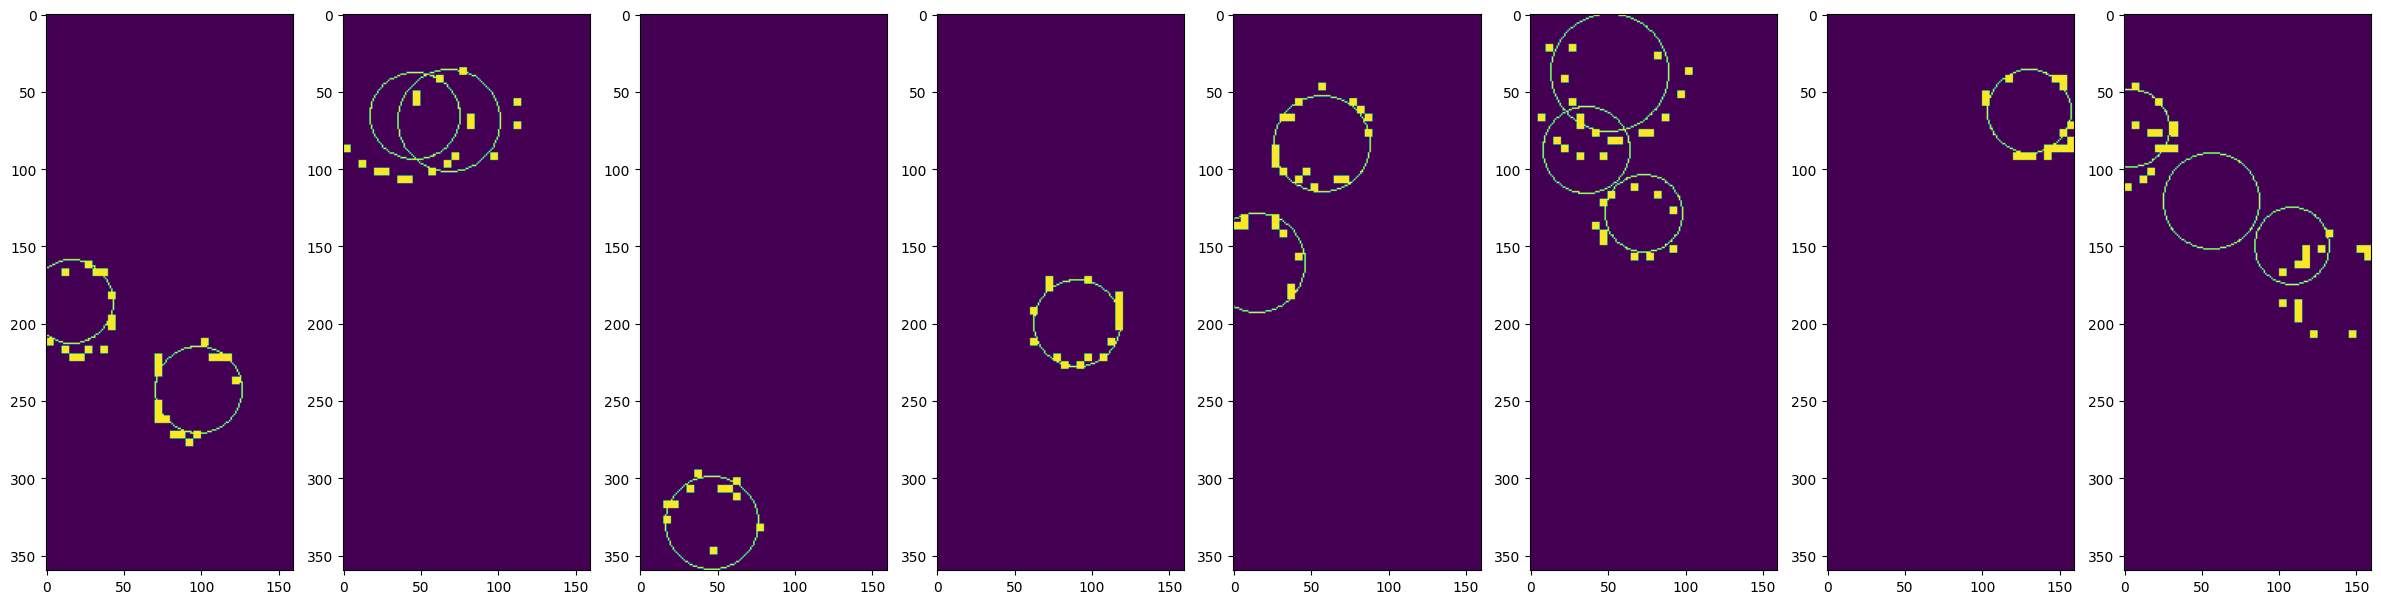

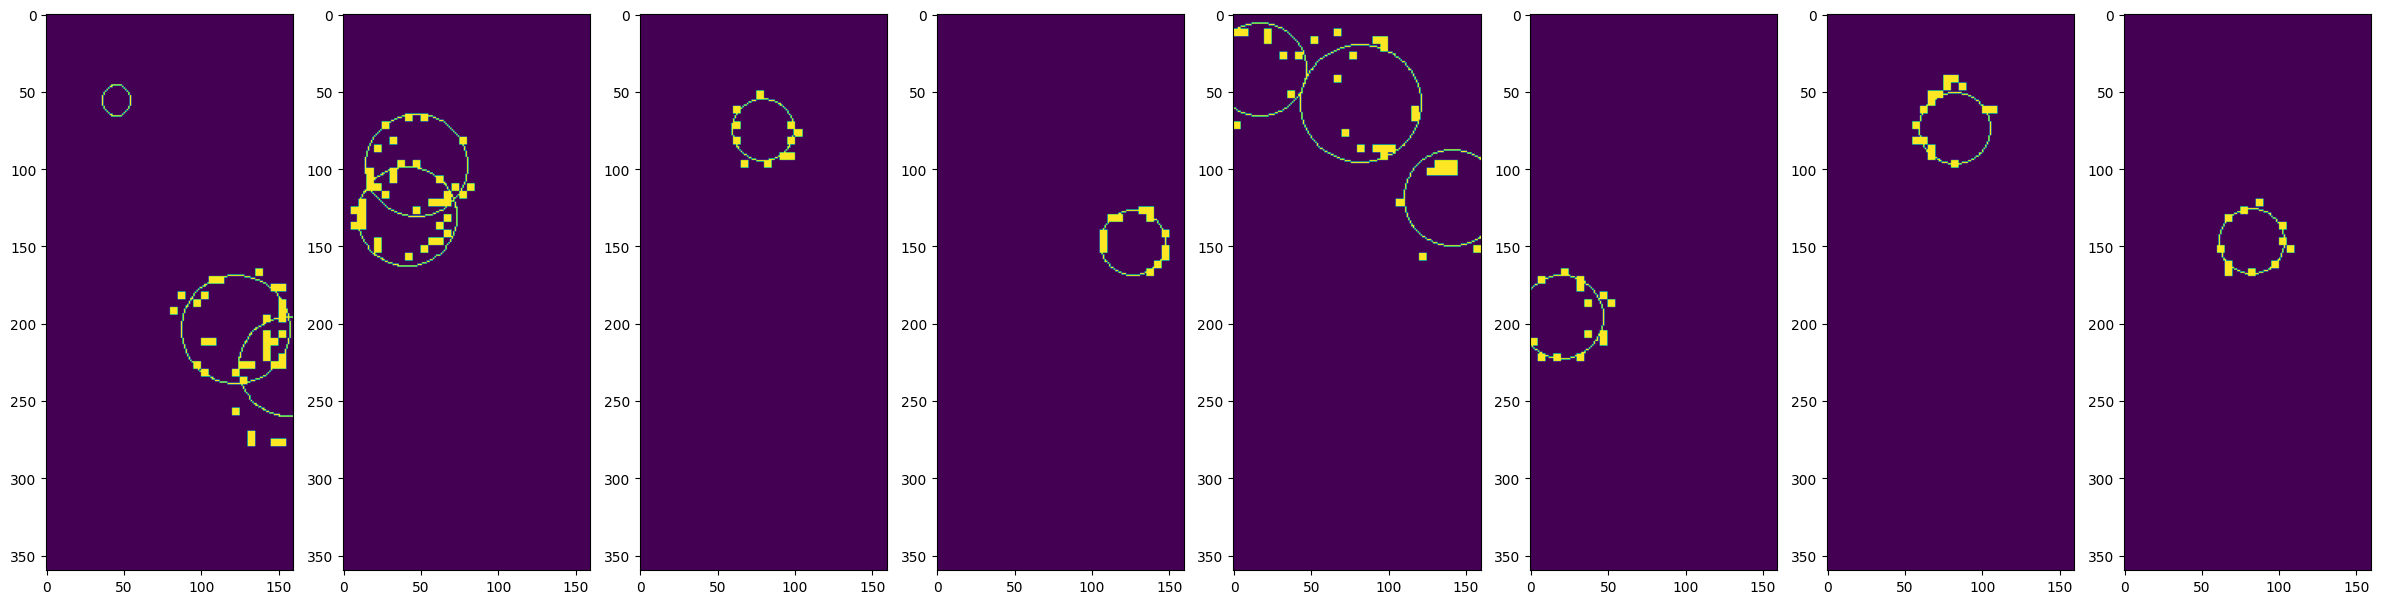

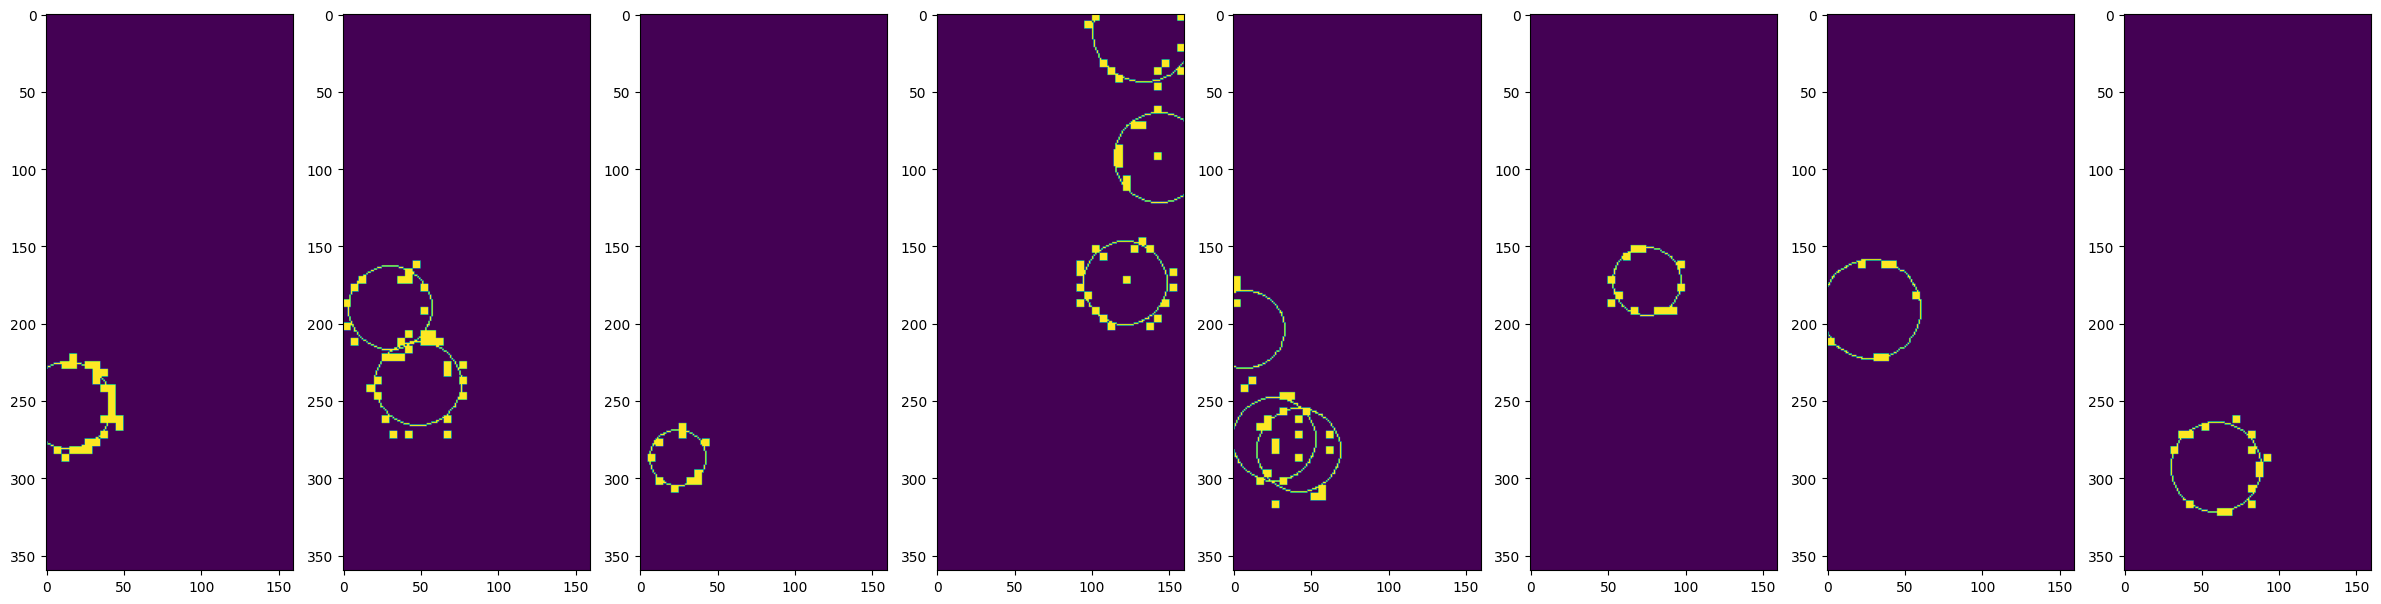

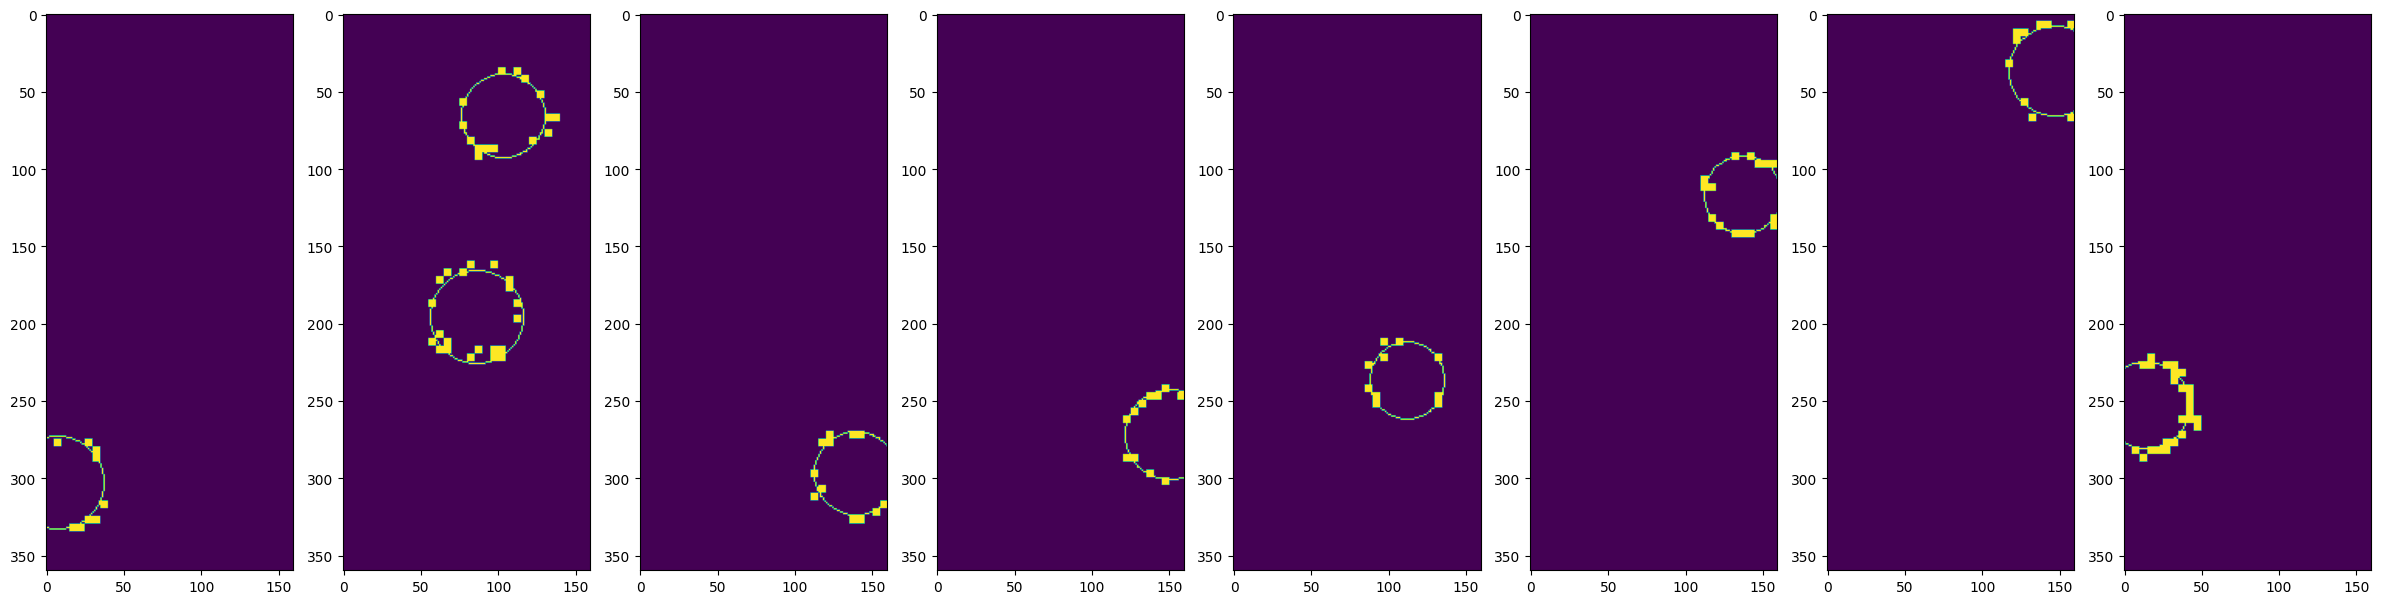

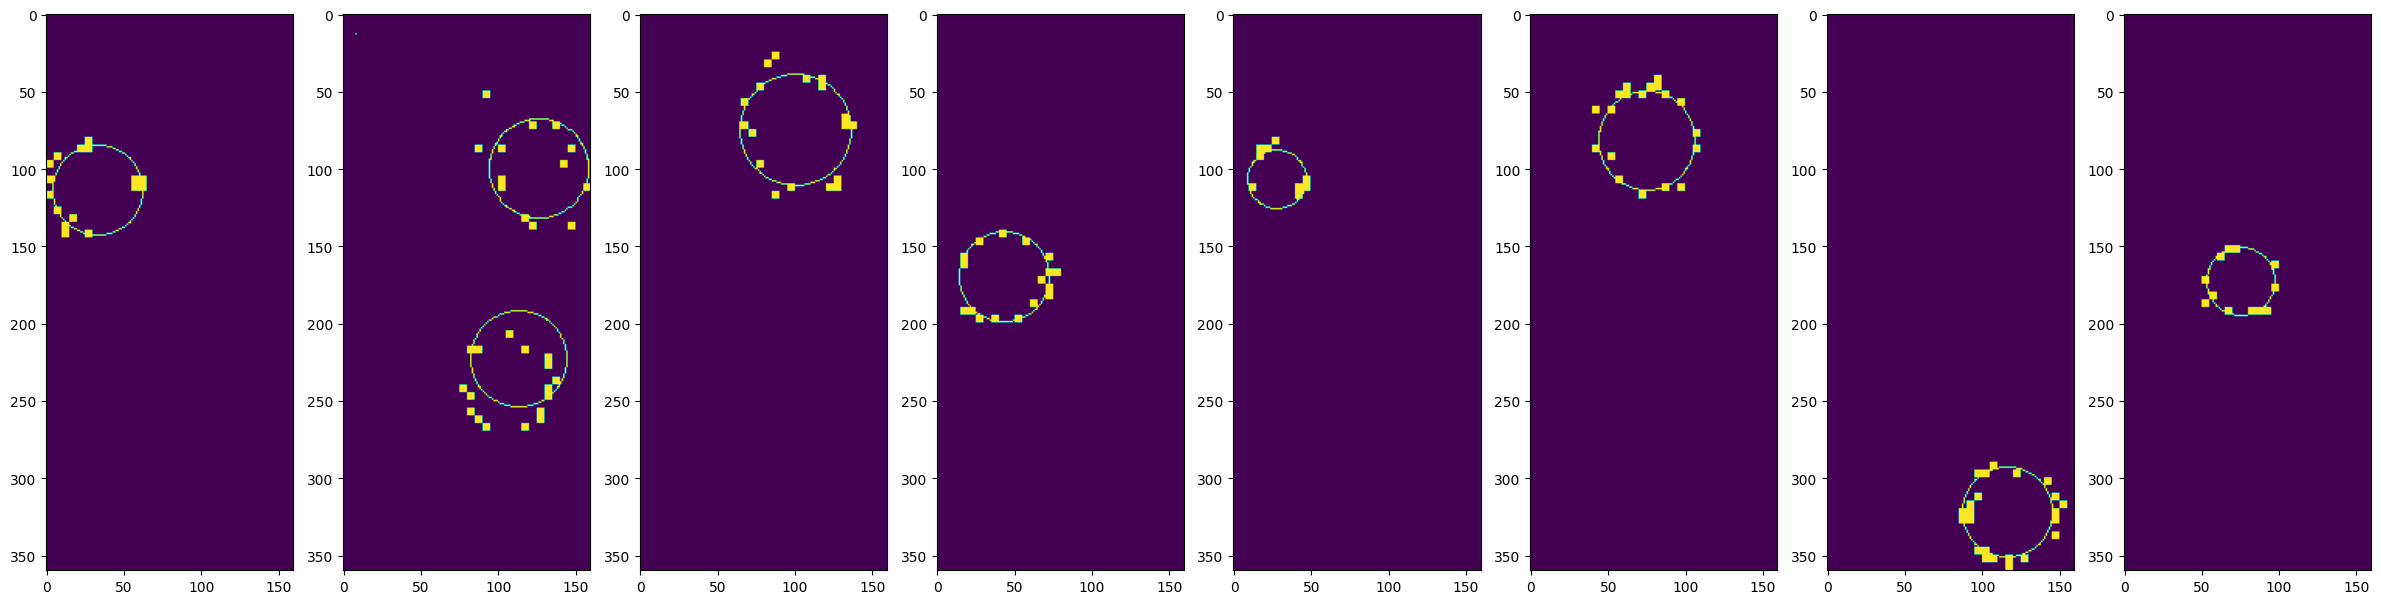

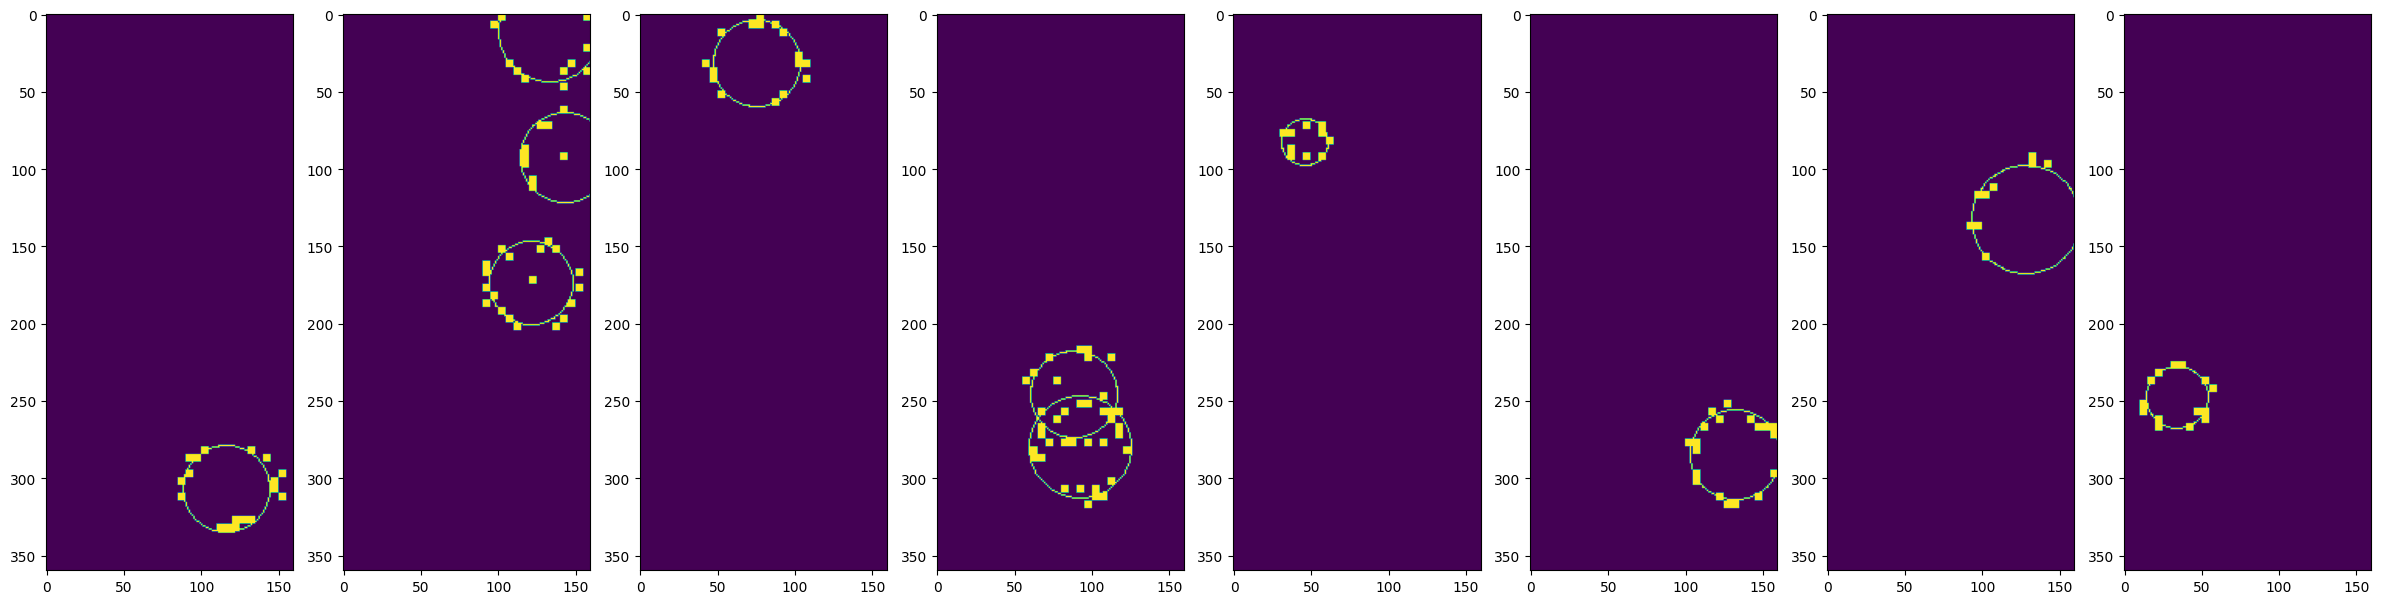

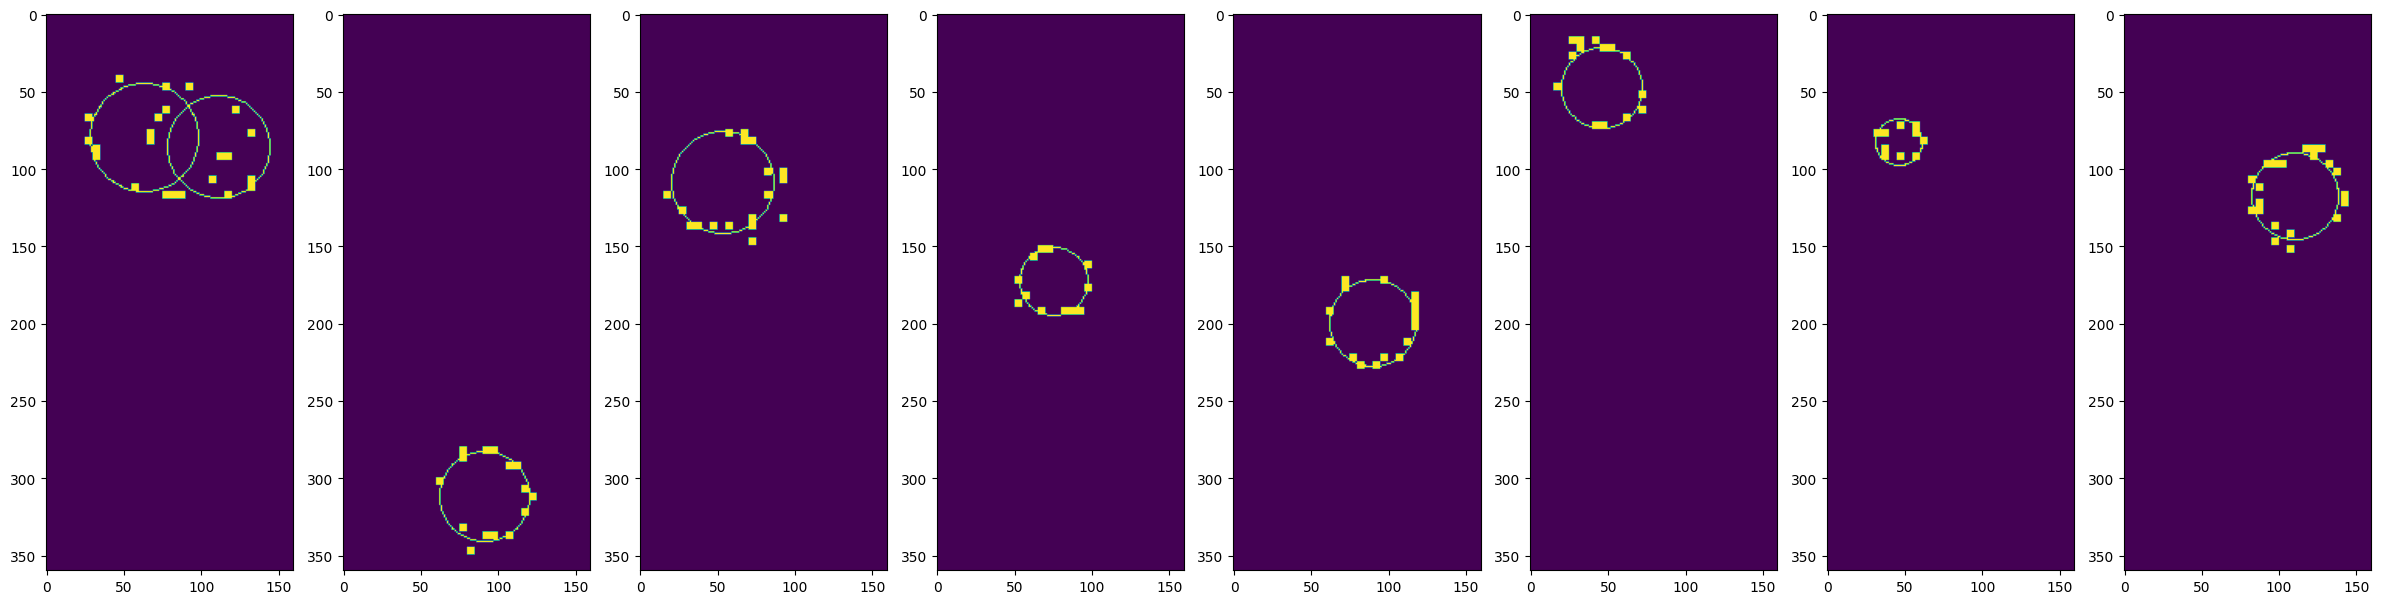

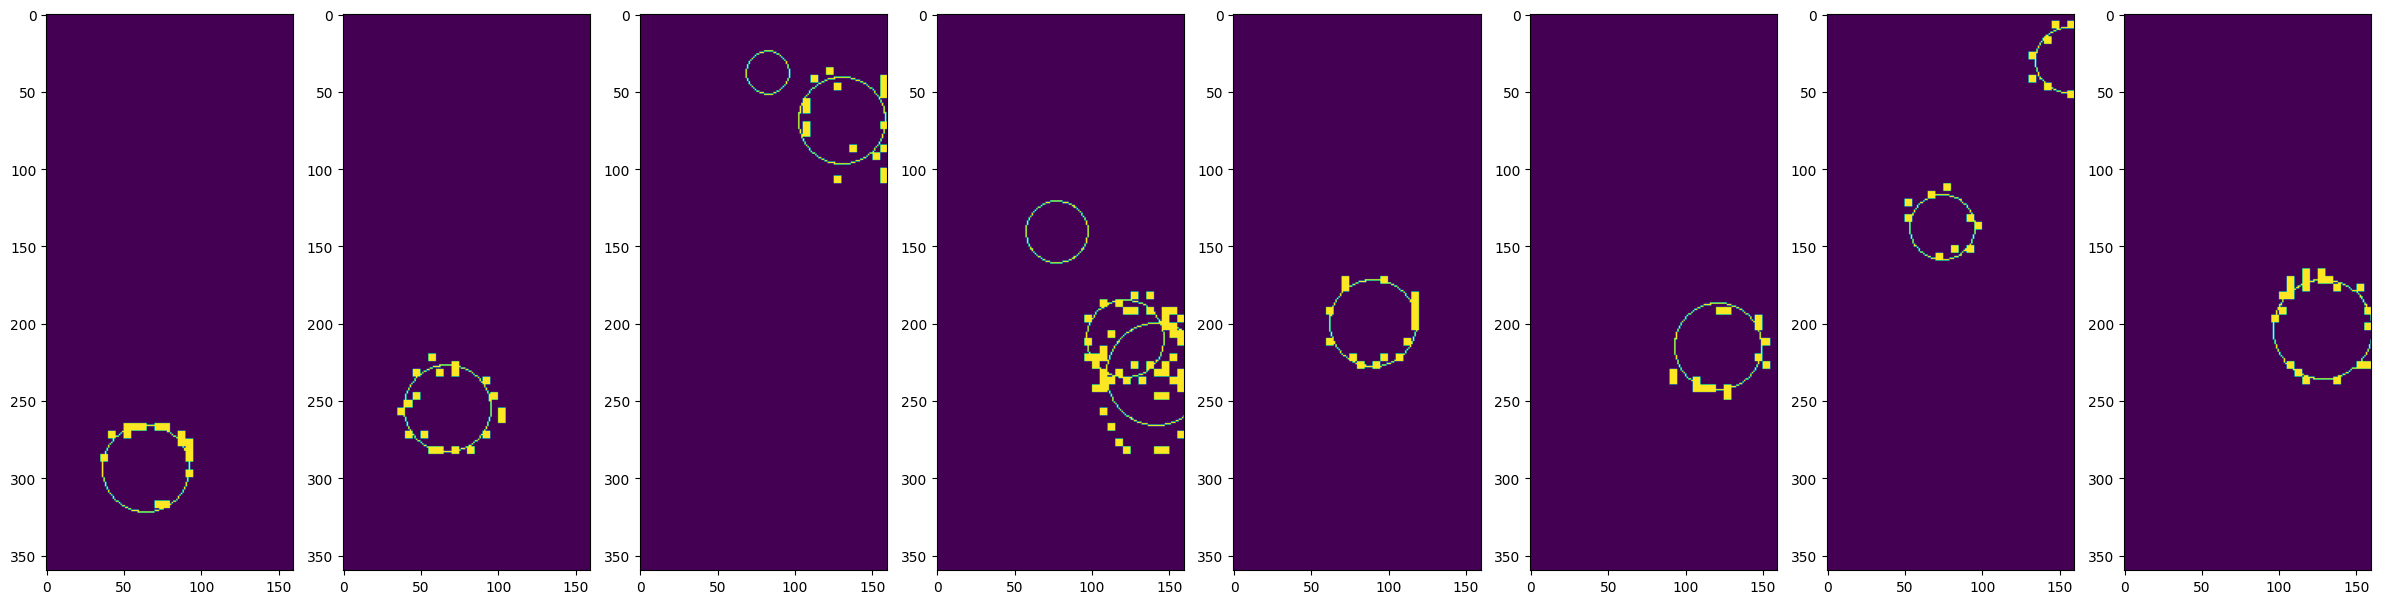

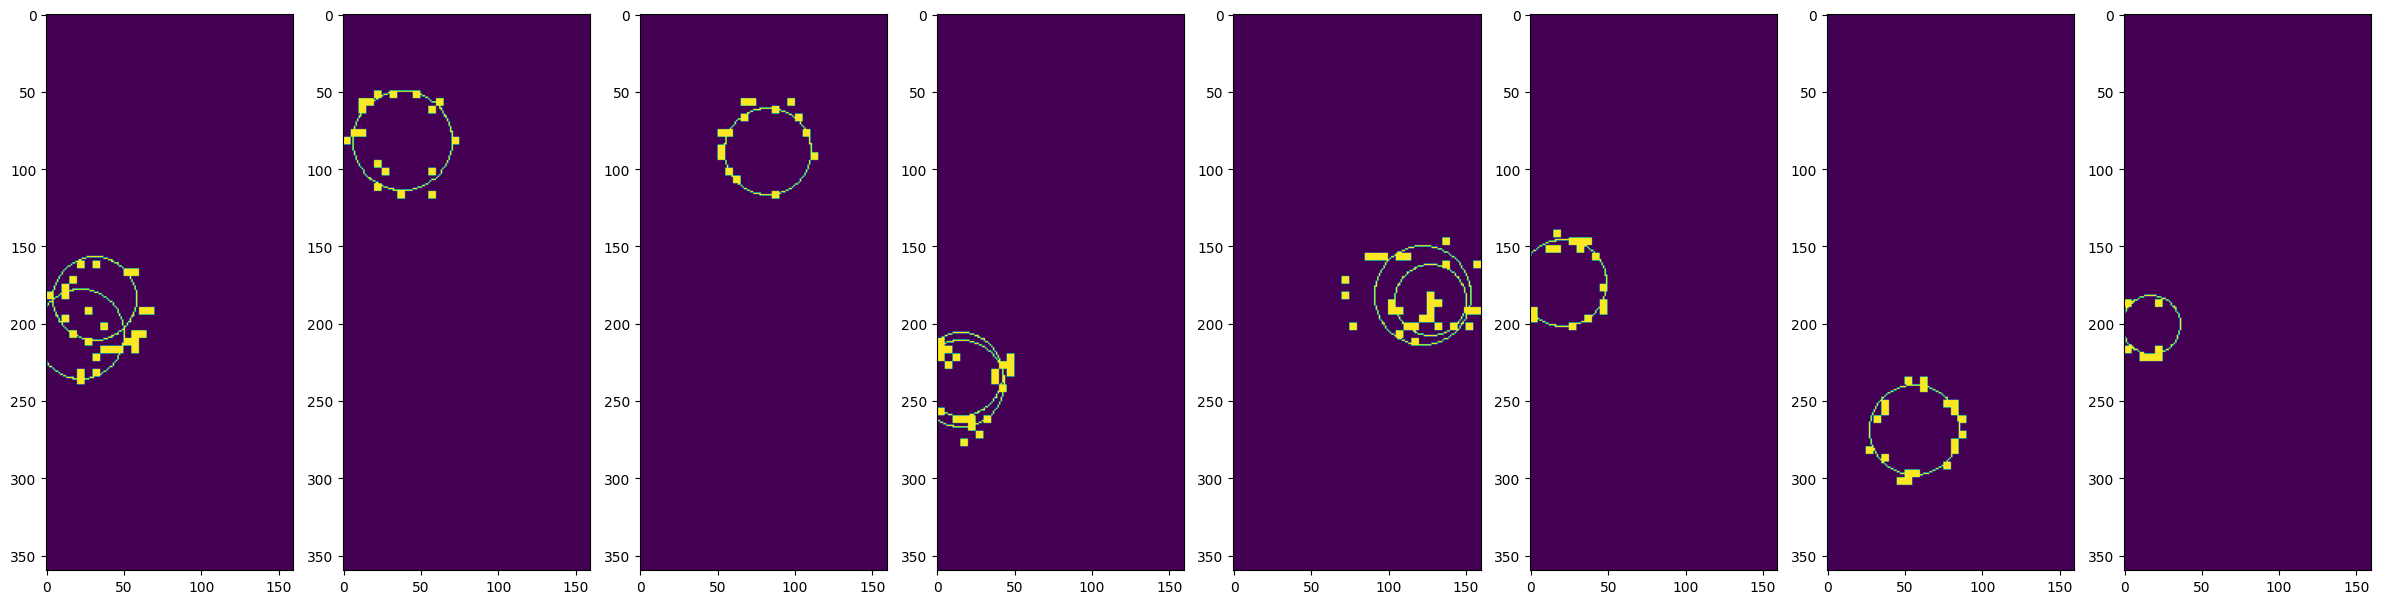

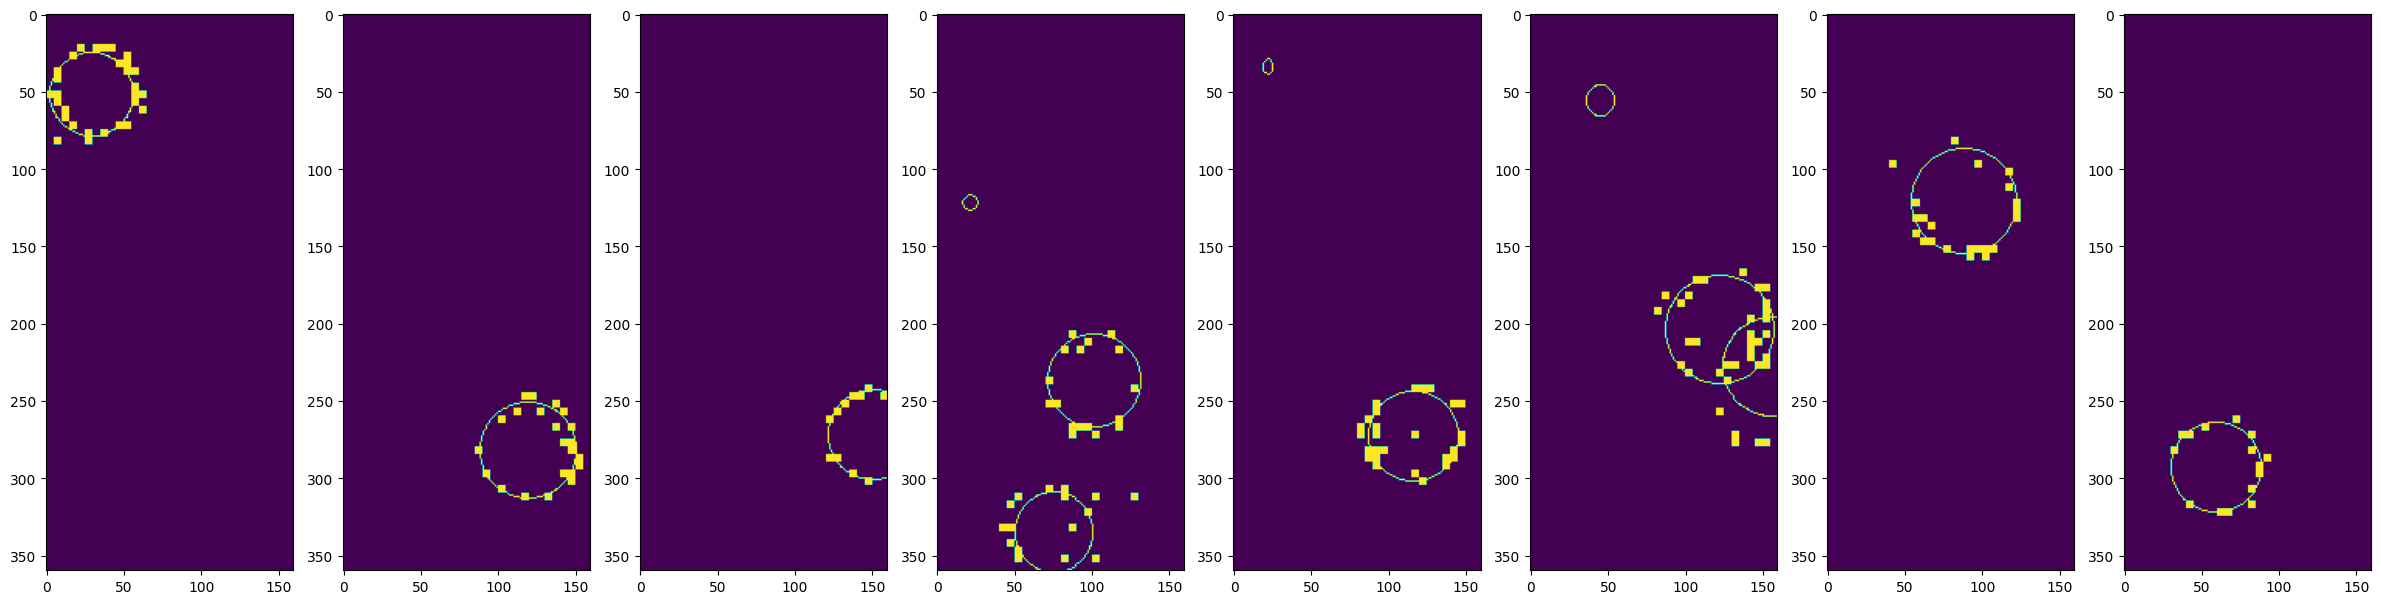

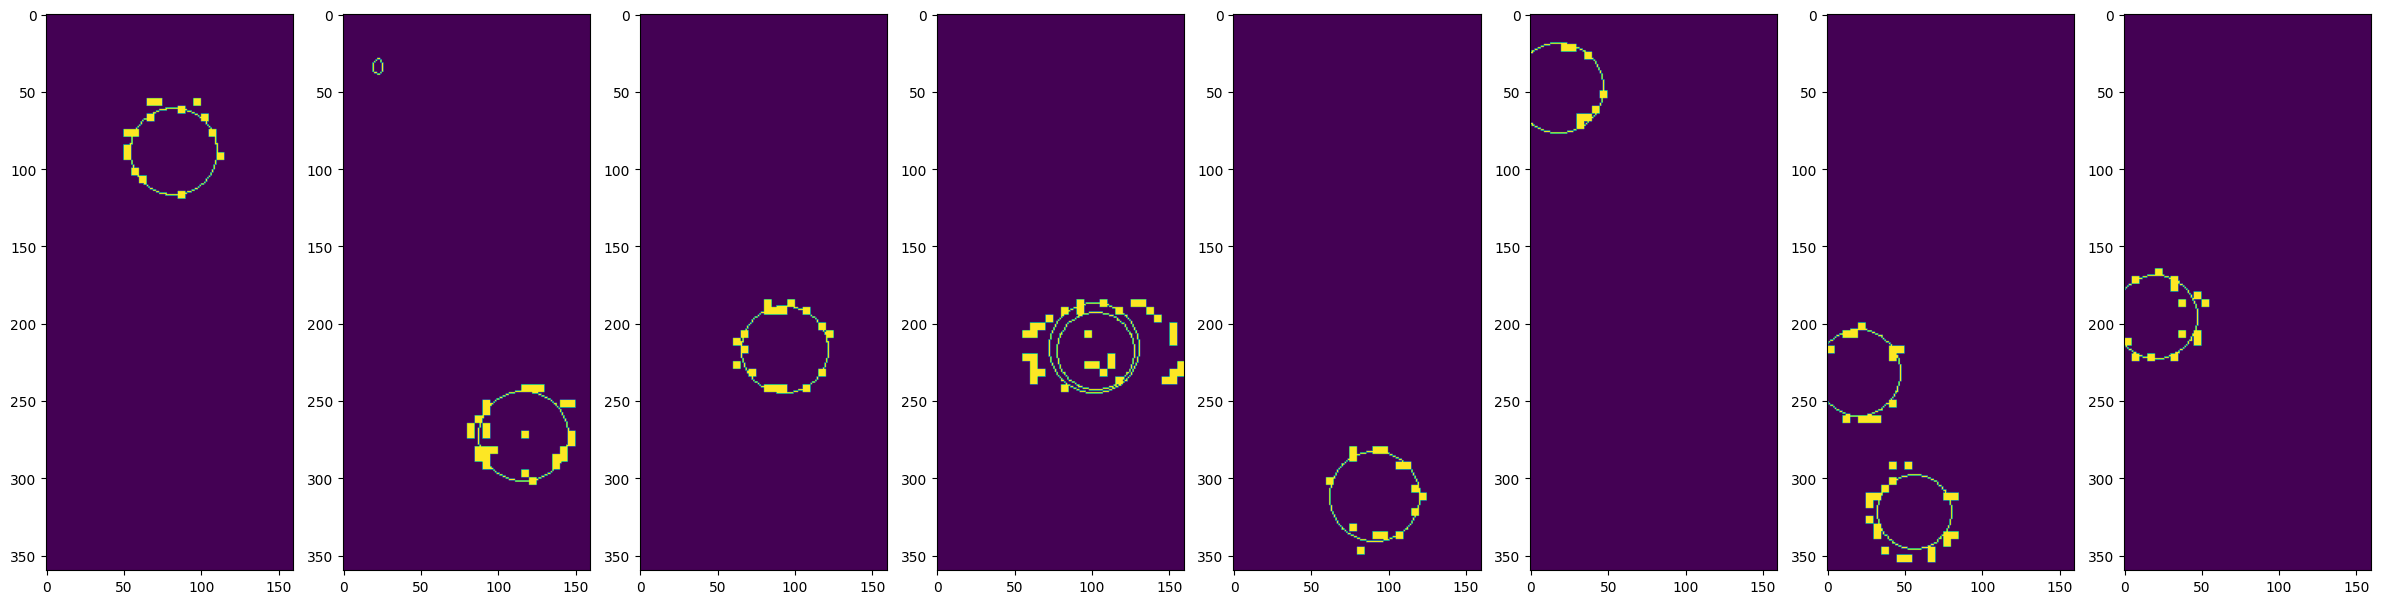

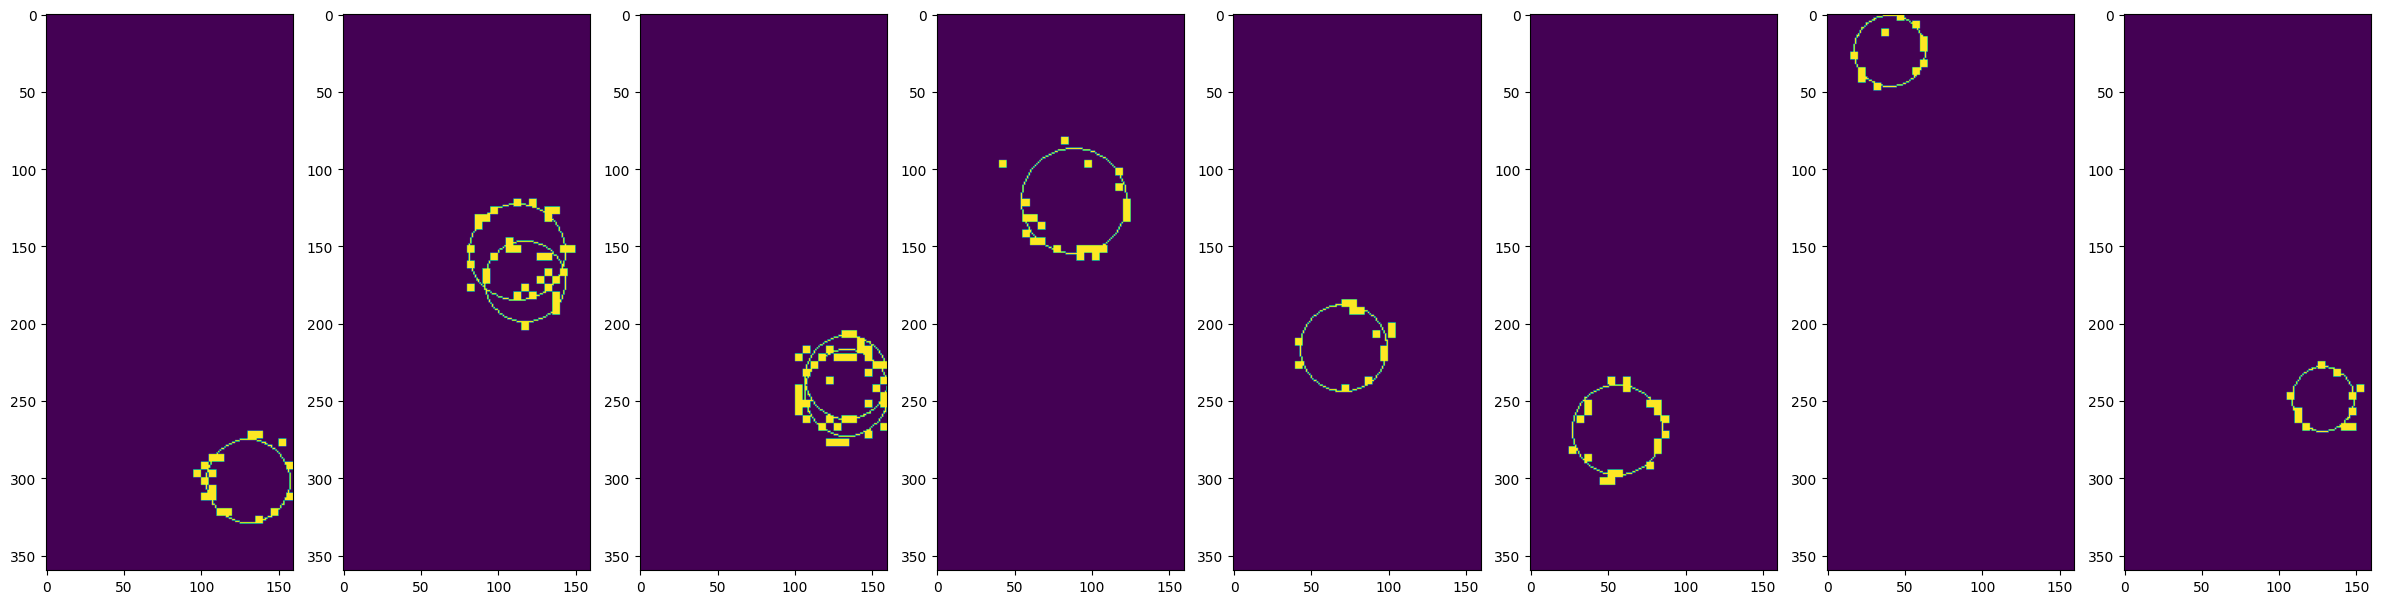

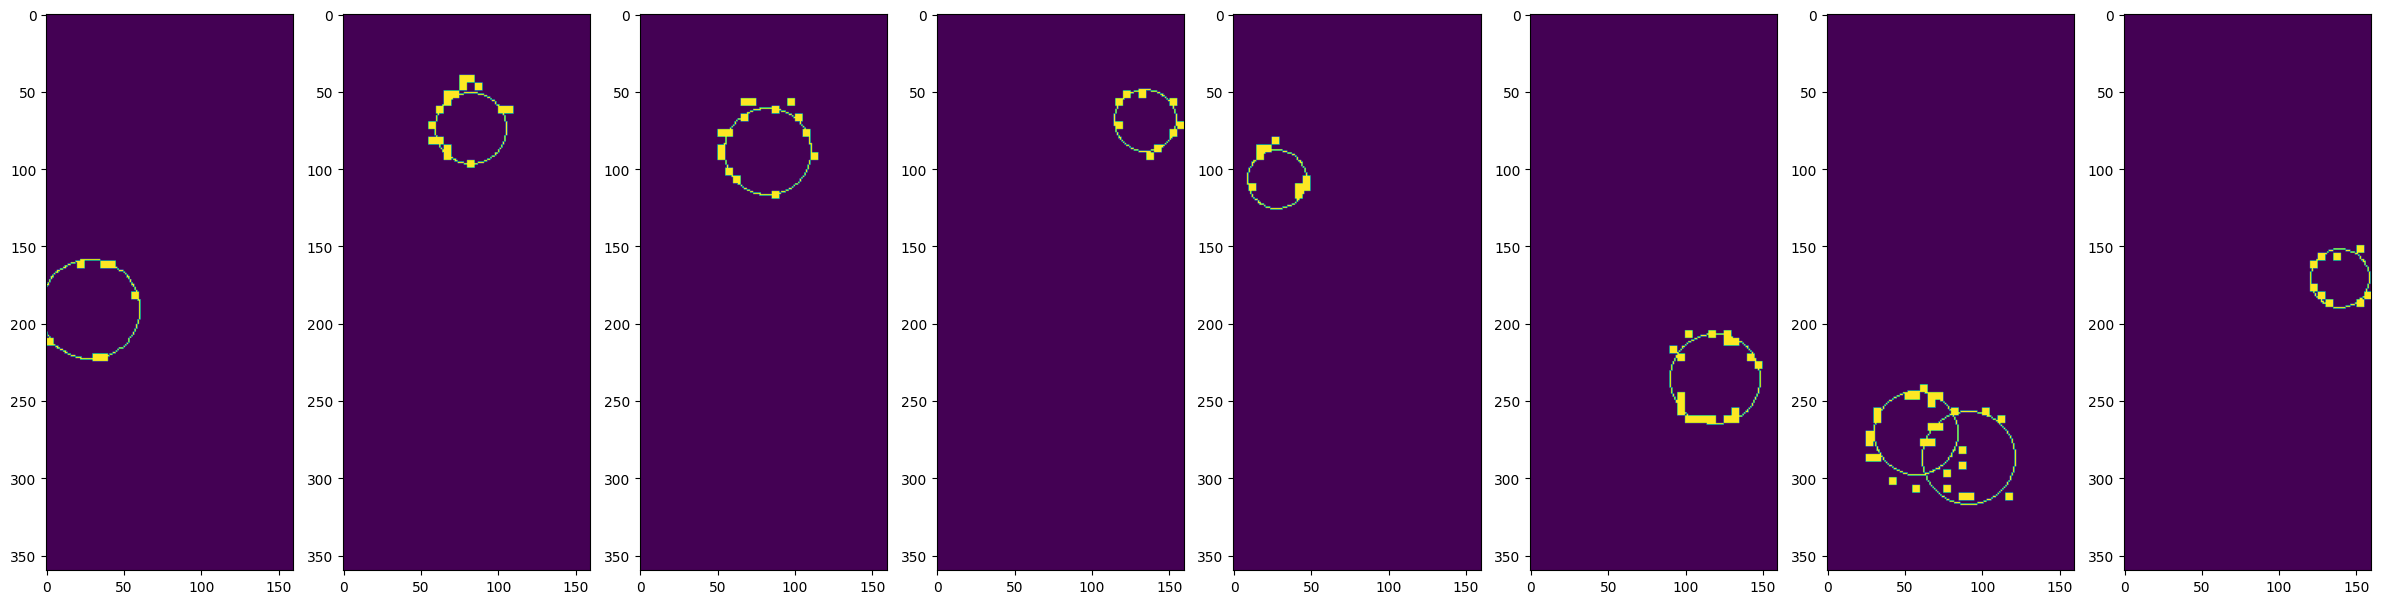

Time for predicting 100 events: 0.07526564598083496 (0.0007526564598083496s/event)


2022-06-01 13:41:32.563398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


In [4]:
model = tf.keras.models.load_model("../models/bmsf2.model")
#model = tf.keras.models.load_model("../models/checkpoints/generator-202206011001.model")
#model = tf.keras.models.load_model("../models/checkpoints/200k-202205162223.model")
#model.summary()

model.evaluate(X, y)

for i in range(20):
    show_predict(np.array(hits_true[:200]), model, i)
#    show_predict(X, model, i)

from time import time
t1 = time()
model.predict(X)
tfp = time() - t1
print("Time for predicting {} events: {} ({}s/event)".format(X.shape[0], tfp, tfp/X.shape[0]))